In [34]:
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from datetime import timedelta, date
from stockstats import StockDataFrame as Sdf
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Convert all prices to USD and fill missing values

In [35]:
currency = pd.read_excel("/Users/zubain/Downloads/Thesis/External Data/CurrencyPair_Historical_Data.xlsx")
currency.sort_values('Date', inplace=True)
currency['Date'] = currency['Date'].astype(str)
currency = currency[['Date', 'GBP', 'EUR', 'CHF', 'JPY', 'DKK', 'HKD', 'MXN', 'PLN', 'SEK', 'THB', 'TWD', 'INR']]
currency.shape
currency.head(5)


(3349, 13)

,Date,GBP,EUR,CHF,JPY,DKK,HKD,MXN,PLN,SEK,THB,TWD,INR
3348,2008-01-01,1.986,1.459,0.882,0.009,0.196,0.128,0.092,0.405,0.155,0.030,0.031,0.025
3347,2008-01-02,1.981,1.473,0.894,0.009,0.198,0.128,0.092,0.407,0.156,0.030,0.031,0.025
3346,2008-01-03,1.971,1.475,0.900,0.009,0.198,0.128,0.092,0.410,0.158,0.030,0.031,0.025
3345,2008-01-04,1.971,1.474,0.902,0.009,0.198,0.128,0.091,0.408,0.157,0.030,0.031,0.025
3344,2008-01-07,1.969,1.469,0.896,0.009,0.197,0.128,0.092,0.407,0.157,0.030,0.031,0.025


In [36]:
def fill_missing_and_curr_convert(currency_df, stock_df):
    # Merging the currency dataset with the stock dataset on Date allows for standardization of dates.
    # Public holidays might fall on different days depending on the country. National holidays might 
    # also break the uniformity. The currency dataset contains standardized values for all weekdays 
    # (Monday-Friday) for every weekday for the duration of the dataset (apart from some USA public holidays)
    df = currency_df.merge(stock_df, on='Date', how='left')
    
    # Static columns
    static_cols = ['industry', 'currency', 'analysts', 'isin']
    # This segment may seem redundant, but it was originally meant to follow a forward fill. A forward fill
    # was leading to many zero correlations while calculating the turbulence index, and causing issues with 
    # the DRL model implementations, hence a bfill is used.
    for col in df.columns:
        if col in static_cols:
            df[col].fillna(method='bfill', inplace=True)
        else:
            df[col].fillna(method='bfill', inplace=True)
            df[col].fillna(0, inplace=True)
    
    # The currency information is extracted
    curr = df['currency'].unique()[0]

    # Do nothing if the currency is USD
    if(stock_df['currency'].unique()[0]=='USD'):
        df['close_in_usd'] = df['CLOSE']
        df['open_in_usd'] = df['OPEN']
        df['high_in_usd'] = df['HIGH']
        df['low_in_usd'] = df['LOW']
        df['exchange_rate'] = 1
    # Convert the prices into USD otherwise
    else:
        df['close_in_usd'] = df[curr]*df['CLOSE']
        df['open_in_usd'] = df[curr]*df['OPEN']
        df['high_in_usd'] = df[curr]*df['HIGH']
        df['low_in_usd'] = df[curr]*df['LOW']
        df['exchange_rate'] = df[curr]
        
    # Reformat the columns 
    df.drop(['GBP', 'EUR', 'CHF', 'JPY', 'DKK', 'HKD', 'MXN', 'PLN', 'SEK', 'THB', 'TWD', 'INR'], axis=1,
            inplace=True)
    df['close_orig'] = df['CLOSE']
    df['open_orig'] = df['OPEN']
    df['high_orig'] = df['HIGH']
    df['low_orig'] = df['LOW']
    df.drop(['CLOSE', 'OPEN', 'HIGH', 'LOW'], axis=1, inplace=True)
    df['close'] = df['close_in_usd']
    df['open'] = df['open_in_usd']
    df['high'] = df['high_in_usd']
    df['low'] = df['low_in_usd']
    
    df.drop(['close_in_usd', 'open_in_usd', 'high_in_usd', 'low_in_usd'], axis=1, inplace=True)
    
    return df

# Add technical indicators

In [37]:
def add_technical_indicator(df):
    """
    Technical indicators (MACD, RSI and Bollinger bands) are calculated using the StockStats library
    """
    df_copy = df.copy()
    stock_df = Sdf.retype(df_copy)
    
    temp_macd = pd.DataFrame(stock_df.get('macd'))
    df_copy['macd'] = temp_macd
    
    temp_rsi = pd.DataFrame(stock_df['rsi_30'])
    df_copy['rsi'] = temp_rsi
    df_copy['rsi'].fillna(0, inplace=True)

    temp_boll = pd.DataFrame(stock_df['boll'])
    df_copy['boll'] = temp_boll
    df_copy['boll'].fillna(0, inplace=True)
    
    df_copy.reset_index(inplace=True)
    df_copy = df_copy[['date', 'high', 'close', 'low', 'open', 'volume', 'currency', 'macd', 'rsi', 'boll']]
    
    return df_copy

# Add turbulence data

This section deals with historical volatility. The tubulence index at any time step is the historical volatility of the prices of the universe of assets up till the time step.

In [6]:
def add_turbulence(df, history):
    """
    Add turbulence index from a precalcualted dataframe
    """
    # Calls the calculate turbulence function
    turbulence_index = calculate_turbulence(df, history)
    
    # Merges the calculated turbulence with the main dataset
    df = df.merge(turbulence_index, on='date')
    df = df.sort_values(['date','currency']).reset_index(drop=True)
    return df

def calculate_turbulence(df, history):
    df_price_pivot=df.pivot(index='date', columns='currency', values='close')
    unique_date = df.date.unique()
    # To ensure sufficient price history, the calculation starts a year after the dataset begins
    start = 252
    turbulence_index = [0]*start
    count=0
    for i in range(start,len(unique_date)):
        # The current prices of every asset at a specific time step
        current_price = df_price_pivot[df_price_pivot.index == unique_date[i]]
        # The historical prices of every asset from the start till the time step
        hist_price = df_price_pivot[[n in unique_date[i-history:i] for n in df_price_pivot.index]]
        cov_temp = hist_price.cov()
        # Current price - mean of historical prices
        current_temp=(current_price - np.mean(hist_price,axis=0))
        
        for j in current_temp.columns:
            # When two or more columns with near zero correlation exist in the dataset, they can cause a singular
            # matrix error while calculating the turbulence index. To mitigate this effect, these columns are
            # removed from the dataset. The main reason why this occurs is due to missing data. This problem does
            # not occur with the currency baskets, but it can occur with any strongly correlated assets. 
            if(cov_temp[j].sum() < 1e-5):
                cov_temp.drop(index=j, columns=j, inplace=True)
                current_temp.drop(columns=j, inplace=True)

        # Here the formula of the turbulence index is applied
        temp = current_temp.values.dot(np.linalg.inv(cov_temp)).dot(current_temp.values.T)

        if temp>0:
            count+=1
            # Start tracking the turbulence index from here
            if count>2:
                turbulence_temp = temp[0][0]
            else:
                #Avoid a large outlier when the turbulence calculation might have just begun
                turbulence_temp=0
        else:
            turbulence_temp=0
        turbulence_index.append(turbulence_temp)
    
    
    turbulence_index = pd.DataFrame({'date':df_price_pivot.index,
                                     'turbulence':turbulence_index})
    
    return turbulence_index

# Add VIX data

This section deals with implied volatility using VIX data from CBOE

In [31]:
# read vix data

vix = pd.read_excel("/Users/zubain/Downloads/Thesis/External Data/VIX_History.xlsx")
vix.sort_values('DATE', inplace=True)
vix['DATE'] = vix['DATE'].astype(str)
vix = vix[['DATE', 'CLOSE']]
vix.shape
vix.head(5)

# final_dates = currency['Date'].unique()

(3232, 2)

,DATE,CLOSE
0,2008-01-02,23.170
1,2008-01-03,22.490
2,2008-01-04,23.940
3,2008-01-07,23.790
4,2008-01-08,25.430


In [159]:
def add_vix(df, vix_df):
#     vix_df.rename({'DATE':'date', 'CLOSE':'vix'}, inplace=True)
    vix.columns = ['date', 'turbulence']
    df = df.merge(vix_df, on='date', how='left')
    df['turbulence'].fillna(method='bfill', inplace=True)
    
    return df

# Compile main dataset with technical indicators, uniform dates and uniform currency

In [42]:
Z_data = '/Users/zubain/Downloads/Thesis/Zubain version/data/Data/'

def compile_dataset() -> pd.DataFrame:
    
    data = pd.DataFrame()
    
    # Every stock's data history is contained within a csv file. This segment adds all file names into
    # a list
    stock_dir = []
    for item in os.listdir(Z_data):
        if not item.startswith('.') and os.path.isfile(os.path.join(Z_data, item)):
            stock_dir.append(item)
        
    num_stocks = len(stock_dir)
    print("Number of stocks: ", num_stocks)
    
    # Looping through every file (stock)
    for i in range(num_stocks):
        df_i = pd.read_excel(Z_data + stock_dir[i])
        df_i['Date'] = df_i['Date'].astype(str)
        
        # Function to fill missing data and convert currency into its US dollar pair, where applicable
        df_with_missing = fill_missing_and_curr_convert(currency, df_i)
        
        # Add the resulting stock's dataset into the main dataset
        data = data.append(df_with_missing, ignore_index=True)
        
    # Sort the dataset by Date and stock
    data.sort_values(by=['Date','isin'], inplace=True)
    
    return data

final_with_missing = compile_dataset()
final_with_missing.shape
final_with_missing.head(5)

Number of stocks:  498


(1667802, 16)

,Date,COUNT,VOLUME,industry,currency,analysts,isin,exchange_rate,close_orig,open_orig,high_orig,low_orig,close,open,high,low
147356,2008-01-01,927.000,17304.017,Chemicals,EUR,6.000,AT0000644505,1.459,35.143,36.000,37.143,35.143,51.270,52.520,54.188,51.270
462162,2008-01-01,338.000,240509.000,Insurance,EUR,6.000,AT0000908504,1.459,34.450,33.500,35.000,33.100,50.259,48.873,51.062,48.290
1570681,2008-01-01,nan,14902.000,Diversified Financial Services,EUR,3.000,BE0003717312,1.459,54.500,53.200,54.500,52.990,79.510,77.613,79.510,77.307
1641010,2008-01-01,nan,123007.000,"Oil, Gas & Consumable Fuels",EUR,8.000,BE0003816338,1.459,11.340,11.990,11.990,11.210,16.544,17.492,17.492,16.354
77027,2008-01-01,nan,34894.000,Semiconductors & Semiconductor Equipment,EUR,11.000,BE0165385973,1.459,4.570,4.700,4.700,4.570,6.667,6.857,6.857,6.667


In [195]:
"""A similar test as above, but without filling any missing data, to calculate some statistics"""

data = pd.DataFrame()
    
stock_dir = []
for item in os.listdir(Z_data):
    if not item.startswith('.') and os.path.isfile(os.path.join(Z_data, item)):
        stock_dir.append(item)

num_stocks = len(stock_dir)
print("Number of stocks: ", num_stocks)

#     final_dates = get_all_dates(orig_data_filepath)

for i in range(num_stocks):
    df_i = pd.read_excel(Z_data + stock_dir[i])
    df_i['Date'] = df_i['Date'].astype(str)
#     df_with_missing = fill_missing_and_curr_convert(currency, df_i)
#         df_with_tech = add_technical_indicator(df_with_missing)

    data = data.append(df_i, ignore_index=True)

data.sort_values(by=['Date','isin'], inplace=True)

data.shape
data.head(5)

Number of stocks:  498


(1231177, 11)

,Date,HIGH,CLOSE,LOW,OPEN,COUNT,VOLUME,industry,currency,analysts,isin
948736,2008-01-02,0.840,0.840,0.840,0.840,nan,321.429,Health Care Equipment & Supplies,USD,9.000,US09062W2044
54274,2008-01-02,28.250,28.000,26.500,26.500,nan,4514.000,Banks,USD,4.000,US1640241014
315463,2008-01-02,25.673,25.673,25.673,25.673,nan,400.000,Banks,USD,6.000,US3208661062
948737,2008-01-03,0.840,0.770,0.770,0.770,nan,435.429,Health Care Equipment & Supplies,USD,9.000,US09062W2044
54275,2008-01-03,26.000,26.000,26.000,26.000,nan,100.000,Banks,USD,4.000,US1640241014


In [198]:
# Maximum number of stocks available per year

data['year'] = data['Date'].str[:4]
data.groupby('year').agg({'isin':'nunique'})

,isin
year,
2008,309
2009,346
2010,361
2011,371
2012,379
2013,401
2014,413
2015,421
2016,438


# Analysis of overall returns of every stock in the dataset

In [126]:
stocks_before_2016 = final_with_missing[final_with_missing['Date']>='2016-01-01']
stocks_2016_grouped = stocks_before_2016.groupby('isin').agg({'close': ['first', 'last']})
stocks_2016_grouped.columns = [' '.join(col).strip() for col in stocks_2016_grouped.columns.values]
stocks_2016_grouped['return'] = stocks_2016_grouped['close last']/stocks_2016_grouped['close first']
stocks_2016_grouped[stocks_2016_grouped['return']>5]

,close first,close last,return
isin,,,
CA67000B1040,13.220,108.720,8.224
CH0025751329,14.778,84.179,5.696
GB00BBQ38507,300.859,2738.316,9.102
JP3163900008,0.278,6.758,24.350
JP3174190003,4.254,31.344,7.369
JP3305560009,3.083,25.622,8.310
JP3399780000,9.296,53.856,5.793
JP3507750002,3.196,77.280,24.184
JP3610400008,6.349,97.632,15.376


In [13]:
final_with_missing['VOLUME'].mean()

4288300.608764817

In [191]:
final_with_missing_2016 = final_with_missing[final_with_missing['Date']>='2016-01-01']
stocks_grouped = final_with_missing_2016.groupby('isin').agg({'close': ['first', 'last'], 'VOLUME': 'mean'})
stocks_grouped.columns = [' '.join(col).strip() for col in stocks_grouped.columns.values]
stocks_grouped['return'] = stocks_grouped['close last']/stocks_grouped['close first']
stocks_grouped[(stocks_grouped['return']<0.3)].count()

close first    24
close last     24
VOLUME mean    24
return         24
dtype: int64

# Converting stock dataset into basket of stocks

In [129]:
def new_weighting(df):
    new_df = pd.DataFrame()
    currencies = df.currency.unique()
    
    # Looping through every currency. Pivoting the 'close', 'open', 'high', 'low' and 'volume' fields
    # to calculate their mean values. 
    
    for currency in currencies:
        df_curr = df[df['currency']==currency]
        extra_df = pd.DataFrame()
        df_close_pivot = df_curr.pivot(index='Date', columns='isin', values='close')
        num_cols = df_close_pivot.shape[1]
        df_close_pivot['total_close'] = df_close_pivot.sum(axis=1)/num_cols
        
        df_open_pivot = df_curr.pivot(index='Date', columns='isin', values='open')
        df_open_pivot['total_open'] = df_open_pivot.sum(axis=1)/num_cols
        
        df_high_pivot = df_curr.pivot(index='Date', columns='isin', values='high')
        df_high_pivot['total_high'] = df_high_pivot.sum(axis=1)/num_cols
        
        df_low_pivot = df_curr.pivot(index='Date', columns='isin', values='low')
        df_low_pivot['total_low'] = df_low_pivot.sum(axis=1)/num_cols

        df_volume_pivot=df_curr.pivot(index='Date', columns='isin', values='VOLUME')
        df_volume_pivot['total_volume'] = df_volume_pivot.sum(axis=1)/num_cols

        extra_df['close'] = df_close_pivot['total_close']
        extra_df['open'] = df_open_pivot['total_open']
        extra_df['high'] = df_high_pivot['total_high']
        extra_df['low'] = df_low_pivot['total_low']
        extra_df['volume'] = df_volume_pivot['total_volume']
        extra_df['currency'] = currency
        extra_df.reset_index(inplace=True)

        new_df = pd.concat([new_df, extra_df])
        print(new_df.shape)
    
    return new_df

In [130]:
# BANCA MONTE DEI PASCHI DI SIENA is another stock that has been removed, went bankrupt during the dataset analysis
# period
final_with_missing = final_with_missing[final_with_missing['isin']!='IT0005218752']

In [131]:
# Convert the dataset derived from the compile_dataset() function to a currency basket

final_weight = new_weighting(final_with_missing)
final_weight

(3349, 7)
(6698, 7)
(10047, 7)
(13396, 7)
(16745, 7)
(20094, 7)
(23443, 7)
(26792, 7)
(30141, 7)
(33490, 7)
(36839, 7)
(40188, 7)
(43537, 7)


,Date,close,open,high,low,volume,currency
0,2008-01-01,23.925,23.948,24.567,23.328,3147453.073,EUR
1,2008-01-02,24.151,24.174,24.800,23.548,3147453.073,EUR
2,2008-01-03,24.185,24.208,24.835,23.582,3147453.073,EUR
3,2008-01-04,24.180,24.204,24.830,23.577,3147453.073,EUR
4,2008-01-07,24.089,24.112,24.736,23.488,3147453.073,EUR
...,...,...,...,...,...,...,...
3344,2020-10-26,5.469,5.436,5.523,5.397,4004133.000,TWD
3345,2020-10-27,5.471,5.401,5.514,5.340,6271009.000,TWD
3346,2020-10-28,5.425,5.469,5.486,5.381,3780466.000,TWD
3347,2020-10-29,5.346,5.329,5.392,5.266,3040280.000,TWD


In [132]:
# Add technical indicators to the baskets

final_weight_tech = add_technical_indicator(final_weight)
final_weight_tech.head(5)
final_weight_tech.shape

,date,high,close,low,open,volume,currency,macd,rsi,boll
0,2008-01-01,24.567,23.925,23.328,23.948,3147453.073,EUR,0.000,0.000,23.925
1,2008-01-02,24.800,24.151,23.548,24.174,3147453.073,EUR,0.005,100.000,24.038
2,2008-01-03,24.835,24.185,23.582,24.208,3147453.073,EUR,0.008,100.000,24.087
3,2008-01-04,24.830,24.180,23.577,24.204,3147453.073,EUR,0.008,98.030,24.110
4,2008-01-07,24.736,24.089,23.488,24.112,3147453.073,EUR,0.005,71.011,24.106


(43537, 10)

In [133]:
# Save the currency basket dataset
final_weight_tech.to_csv('final_weight_tech.csv')

In [160]:
# Add vix information to the currency basket

final_weight_vix = add_vix(final_weight_tech, vix)
final_weight_vix.shape
final_weight_vix.head(5)

(43537, 11)

,date,high,close,low,open,volume,currency,macd,rsi,boll,turbulence
0,2008-01-01,24.567,23.925,23.328,23.948,3147453.073,EUR,0.000,0.000,23.925,23.170
1,2008-01-02,24.800,24.151,23.548,24.174,3147453.073,EUR,0.005,100.000,24.038,23.170
2,2008-01-03,24.835,24.185,23.582,24.208,3147453.073,EUR,0.008,100.000,24.087,22.490
3,2008-01-04,24.830,24.180,23.577,24.204,3147453.073,EUR,0.008,98.030,24.110,23.940
4,2008-01-07,24.736,24.089,23.488,24.112,3147453.073,EUR,0.005,71.011,24.106,23.790


# VIX analysis

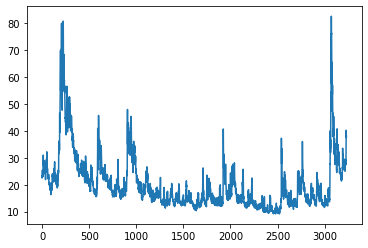

In [161]:
plt.plot(vix['turbulence'])

In [163]:
# This is to check the correlation of vix against every basket, to check if a negative corr

for i in final_weight_vix.currency.unique():
    final_weight_vix_i = final_weight_vix[final_weight_vix['currency']==i]
    print(i)
    print(final_weight_vix_i['close'].corr(final_weight_vix_i['turbulence']))

EUR
-0.4160110586801393
USD
-0.41210591668307256
CHF
-0.03650325232132268
DKK
-0.5345457030254774
GBP
-0.49827496551778067
HKD
-0.633745825675284
INR
-0.30336862555652444
JPY
-0.2851967946121865
MXN
-0.6917608258175227
PLN
-0.5317324844339831
SEK
-0.4769522666040742
THB
-0.6490667532645112
TWD
-0.03639714945018238


In [183]:
final_weight_vix_2020 = final_weight_vix[final_weight_vix['date']>='2020-01-01']

for i in final_weight_vix_2020.currency.unique():
    final_weight_vix_2020_i = final_weight_vix_2020[final_weight_vix_2020['currency']==i]
    print(i)
    print(final_weight_vix_2020_i['close'].corr(final_weight_vix_2020_i['turbulence']))

EUR
-0.7857372724009535
USD
-0.8374978207215297
CHF
-0.27120306865540683
DKK
-0.5505635548558846
GBP
-0.9127947288870658
HKD
-0.3707489996389216
INR
-0.7934546129950552
JPY
-0.8614509650313178
MXN
-0.5717229404006858
PLN
-0.8400313907451068
SEK
-0.6110265666390906
THB
-0.6506854691575044
TWD
-0.35259440830472233


In [164]:
final_weight_vix.to_csv('final_weight_vix.csv')

# Turbulence analysis

Volatility certainly plays a big role in defining the agent's strategy to react in a crash-sensitive market. The time period for which volatility is calculated needs to be decided, as well as the turbulence threshold, because if the entire time series is taken, then volatility indications can be quite lagging

In [4]:
final_weight_tech = pd.read_csv('final_weight_tech.csv')

In [7]:
# final_with_turbulence_21 = add_turbulence(final_weight_tech, 21)
# final_with_turbulence_21['turbulence'].max()
final_with_turbulence_63 = add_turbulence(final_weight_tech, 63)
final_with_turbulence_63['turbulence'].max()
final_with_turbulence_126 = add_turbulence(final_weight_tech, 126)
final_with_turbulence_126['turbulence'].max()
final_with_turbulence_252 = add_turbulence(final_weight_tech, 252)
final_with_turbulence_252['turbulence'].max()
# n = len(final_weight_tech['date'].unique())
# final_with_turbulence_n = add_turbulence(final_weight_tech, n)
# final_with_turbulence_n['turbulence'].max()

408.40846422084695

176.70135590783582

146.70403088741506

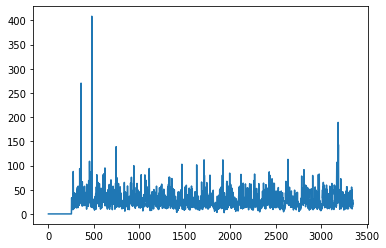

In [20]:
a = final_with_turbulence_63.groupby(['date', 'turbulence']).count().reset_index()[['date', 'turbulence']]
plt.plot(a['turbulence'])

# Plotting the currency baskets

Text(0.5, 1.0, 'EUR')

Text(0.5, 1.0, 'GBP')

Text(0.5, 1.0, 'CHF')

Text(0.5, 1.0, 'INR')

Text(0.5, 1.0, 'HKD')

Text(0.5, 1.0, 'JPY')

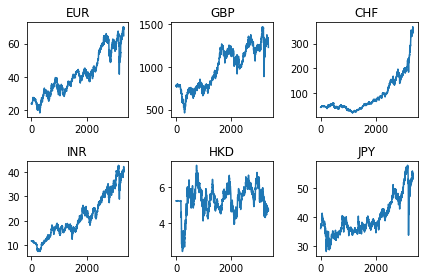

In [228]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].plot(final_weight[final_weight['currency']=='EUR']['close'])
axs[0, 0].set_title("EUR")
axs[0, 1].plot(final_weight[final_weight['currency']=='GBP']['close'])
axs[0, 1].set_title("GBP")
# axs[1, 0].sharex(axs[0, 0])
axs[0, 2].plot(final_weight[final_weight['currency']=='CHF']['close'])
axs[0, 2].set_title("CHF")
axs[1, 0].plot(final_weight[final_weight['currency']=='INR']['close'])
axs[1, 0].set_title("INR")
axs[1, 1].plot(final_weight[final_weight['currency']=='HKD']['close'])
axs[1, 1].set_title("HKD")
axs[1, 2].plot(final_weight[final_weight['currency']=='JPY']['close'])
axs[1, 2].set_title("JPY")
fig.tight_layout()
# fig.savefig('Top6Baskets.png')

Text(0.5, 1.0, 'DKK')

Text(0.5, 1.0, 'MXN')

Text(0.5, 1.0, 'PLN')

Text(0.5, 1.0, 'SEK')

Text(0.5, 1.0, 'THB')

Text(0.5, 1.0, 'TWD')

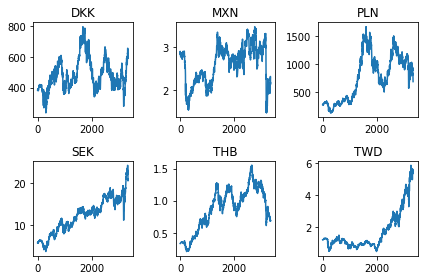

In [226]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].plot(final_weight[final_weight['currency']=='DKK']['close'])
axs[0, 0].set_title("DKK")
axs[0, 1].plot(final_weight[final_weight['currency']=='MXN']['close'])
axs[0, 1].set_title("MXN")
# axs[1, 0].sharex(axs[0, 0])
axs[0, 2].plot(final_weight[final_weight['currency']=='PLN']['close'])
axs[0, 2].set_title("PLN")
axs[1, 0].plot(final_weight[final_weight['currency']=='SEK']['close'])
axs[1, 0].set_title("SEK")
axs[1, 1].plot(final_weight[final_weight['currency']=='THB']['close'])
axs[1, 1].set_title("THB")
axs[1, 2].plot(final_weight[final_weight['currency']=='TWD']['close'])
axs[1, 2].set_title("TWD")
fig.tight_layout()
fig.savefig('Bottom6Baskets.png')

Text(0.5, 1.0, 'USD')

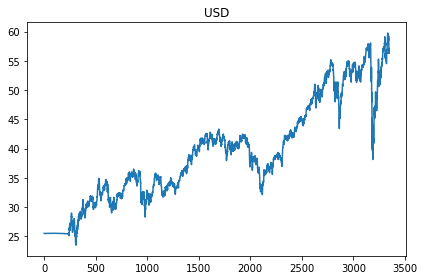

In [232]:
fig, ax = plt.subplots()
ax.plot(final_weight[final_weight['currency']=='USD']['close'])
ax.set_title('USD')
fig.tight_layout()
fig.savefig('USDBasket.png')

# Read in IWDA data

In [109]:
IWDA = pd.read_csv("/Users/zubain/Downloads/Thesis/External Data/IWDA.AS.csv")
IWDA = IWDA[IWDA['Date']>='2016-01-01']
IWDA['benchmark_returns'] = np.log(IWDA['Adj Close']/IWDA['Adj Close'].shift(1))
IWDA['year'] = IWDA['Date'].str[:4]
IWDA = IWDA[['Date', 'Adj Close', 'benchmark_returns', 'year']]
IWDA.shape
IWDA.head(5)

(1236, 4)

,Date,Adj Close,benchmark_returns,year
64,2016-01-04,37.060,nan,2016
65,2016-01-05,37.545,0.013,2016
66,2016-01-06,37.070,-0.013,2016
67,2016-01-07,36.150,-0.025,2016
68,2016-01-08,35.370,-0.022,2016


# Function to produce model run results 

The function 'prep_result_data' performs the following functions: 
- Reads in raw results for every run.
- Selects the files that contain the phrases 'value_date' (as these files track the portfolio balance)
- Combines the files into a single dataframe (each file refers to the trading results from one period)
- Combines the dataframe with the benchmark dataframe, to standardize the dates
- Then log returns, standard deviation and Sharpe ratio are calculated based on the relative returns
- Yearly results as well as overall results are calculated and stored in a new dataframe
- This dataframe is the final result

In [395]:
import os
import re

mainpath = "/Users/zubain/Downloads/Thesis/Zubain version 10 stocks/"
folder = mainpath + "results 6 Aug 13 basket vix in input 200 trades allowed A2C MlpPolicy 2.11Mln/"


def prep_result_data(folder_path, currency_dt_df, benchmark_df):
    data = pd.DataFrame()
    
    files = [folder_path+file for file in os.listdir(folder_path) if "value_trade" in file and "csv" in file]
    files.sort(key=os.path.getmtime)

    for i in files:
    #     print(i)
        file_i = pd.read_csv(i)
        file_i.columns = ['Index', 'Value']
        file_i['filename'] = i[158:162]
        data = data.append(file_i)
        
    data.index = list(range(1260))
    data['Date'] = currency_dt_df['Date']
    
    benchmark_compare = benchmark_df.merge(data, on='Date', how='inner')
    benchmark_compare['agent_returns'] = np.log(benchmark_compare['Value']/benchmark_compare['Value'].shift(1))
    benchmark_compare['benchmark_returns'] = np.log(benchmark_compare['Adj Close']/benchmark_compare['Adj Close'].shift(1))
    benchmark_compare['relative_returns'] = benchmark_compare['agent_returns'] - benchmark_compare['benchmark_returns']
    benchmark_compare = benchmark_compare[['Date', 'Adj Close', 'Value', 'agent_returns', 'benchmark_returns', 
                                          'relative_returns', 'year']]
    
    returns_list = []
    volatility_list = []
    sharpe_ratio_list = []
    year_list = []
    
    for yr in benchmark_compare.year.unique():
        benchmark_compare_yr = benchmark_compare[benchmark_compare['year']==yr]
        days = benchmark_compare_yr.shape[0]
        year_list.append(yr)
#         print(yr)
#         print(benchmark_compare_yr.shape)

        returns_yr = benchmark_compare_yr['relative_returns'].sum()
        returns_list.append(returns_yr)
#         print(returns_yr)
        volatility_yr = benchmark_compare_yr['relative_returns'].std()*days**.5
        volatility_list.append(volatility_yr)
#         print(volatility_yr)

        sharpe_ratio_yr = returns_yr/volatility_yr
        sharpe_ratio_list.append(sharpe_ratio_yr)
#         print(sharpe_ratio_yr)
        
    days_all = benchmark_compare.shape[0]
#     print(days)
    returns_all = benchmark_compare['relative_returns'].sum()
    returns_list.append(returns_all)
#         print(returns_yr)
    volatility_all = benchmark_compare['relative_returns'].std()*days_all**.5
    volatility_list.append(volatility_all)
#         print(volatility_yr)

    sharpe_ratio_all = returns_all/volatility_all
    sharpe_ratio_list.append(sharpe_ratio_all)
    
    year_list.append('Overall relative returns')
    
    returns_agent = benchmark_compare['agent_returns'].sum()
    returns_list.append(returns_agent)
#         print(returns_yr)
    volatility_agent = benchmark_compare['agent_returns'].std()*days_all**.5
    volatility_list.append(volatility_agent)
#         print(volatility_yr)

    sharpe_ratio_agent = returns_agent/volatility_agent
    sharpe_ratio_list.append(sharpe_ratio_agent)
    
    year_list.append('Overall agent returns')
    
    returns_benchmark = benchmark_compare['benchmark_returns'].sum()
    returns_list.append(returns_benchmark)
#         print(returns_yr)
    volatility_benchmark = benchmark_compare['benchmark_returns'].std()*days_all**.5
    volatility_list.append(volatility_benchmark)
#         print(volatility_yr)

    sharpe_ratio_benchmark = returns_benchmark/volatility_benchmark
    sharpe_ratio_list.append(sharpe_ratio_benchmark)
    
    year_list.append('Overall benchmark returns')
    
    benchmark_comparison_df = pd.DataFrame({'Year': year_list, 'Returns': returns_list,
                                            'Volatility': volatility_list, 'Sharpe Ratio': sharpe_ratio_list})
    
    return benchmark_compare, benchmark_comparison_df
    


#### All subsequent cells refer to outputs from specific runs. There are 22 results in total, each defined by folder_XX.  Some extra intermediate results are also calculated for some models

In [364]:
folder_1 = mainpath + "results 6 Aug 13 basket vix 30 200 trades allowed/"
vix_30_200, vix_30_200_result = prep_result_data(folder_1, currency_dates, IWDA)
vix_30_200.shape
# first_check.head(5)
vix_30_200.tail(5)
vix_30_200_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,1942908.684,-0.019,0.004,-0.023,2020
1231,2020-10-26,54.760,1929023.093,-0.007,-0.016,0.009,2020
1232,2020-10-27,54.740,1940369.485,0.006,-0.000,0.006,2020
1233,2020-10-28,53.585,1888031.084,-0.027,-0.021,-0.006,2020
1234,2020-10-29,53.920,1887087.070,-0.001,0.006,-0.007,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,-0.157,0.312,-0.503
1,2017,0.177,0.165,1.077
2,2018,-0.054,0.254,-0.214
3,2019,0.066,0.169,0.390
4,2020,0.234,0.289,0.810
5,Overall relative returns,0.266,0.548,0.486
6,Overall agent returns,0.641,0.410,1.564
7,Overall benchmark returns,0.375,0.370,1.013


In [365]:
folder_2 = mainpath + "results 6 Aug 13 basket vix 30 200 trades allowed DDPG/"
vix_30_200_DDPG, vix_30_200_DDPG_result = prep_result_data(folder_2, currency_dates, IWDA)
vix_30_200_DDPG.shape
# first_check.head(5)
vix_30_200_DDPG.tail(5)
vix_30_200_DDPG_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,1598065.162,0.003,0.004,-0.002,2020
1231,2020-10-26,54.760,1592873.526,-0.003,-0.016,0.013,2020
1232,2020-10-27,54.740,1589134.189,-0.002,-0.000,-0.002,2020
1233,2020-10-28,53.585,1579265.131,-0.006,-0.021,0.015,2020
1234,2020-10-29,53.920,1578961.976,-0.000,0.006,-0.006,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,-0.066,0.283,-0.233
1,2017,0.377,0.250,1.511
2,2018,-0.081,0.254,-0.320
3,2019,-0.155,0.234,-0.660
4,2020,0.011,0.269,0.041
5,Overall relative returns,0.087,0.577,0.150
6,Overall agent returns,0.462,0.453,1.019
7,Overall benchmark returns,0.375,0.370,1.013


In [366]:
folder_3 = mainpath + "results 6 Aug 13 basket vix 30 200 trades allowed DDPG 20K steps/"
vix_30_200_DDPG_20K, vix_30_200_DDPG_20K_result = prep_result_data(folder_3, currency_dates, IWDA)
vix_30_200_DDPG_20K.shape
# first_check.head(5)
vix_30_200_DDPG_20K.tail(5)
vix_30_200_DDPG_20K_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,1501269.978,-0.015,0.004,-0.020,2020
1231,2020-10-26,54.760,1488605.840,-0.008,-0.016,0.008,2020
1232,2020-10-27,54.740,1496990.125,0.006,-0.000,0.006,2020
1233,2020-10-28,53.585,1466087.744,-0.021,-0.021,0.000,2020
1234,2020-10-29,53.920,1465354.700,-0.001,0.006,-0.007,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,-0.199,0.357,-0.557
1,2017,0.283,0.227,1.242
2,2018,-0.341,0.245,-1.393
3,2019,0.015,0.253,0.058
4,2020,0.258,0.327,0.789
5,Overall relative returns,0.015,0.640,0.024
6,Overall agent returns,0.390,0.521,0.749
7,Overall benchmark returns,0.375,0.370,1.013


In [367]:
folder_4 = mainpath + "results 6 Aug 13 basket vix 30 200 trades allowed PPO/"
vix_30_200_PPO, vix_30_200_PPO_result = prep_result_data(folder_4, currency_dates, IWDA)
vix_30_200_PPO.shape
# first_check.head(5)
vix_30_200_PPO.tail(5)
vix_30_200_PPO_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,1459309.308,-0.001,0.004,-0.006,2020
1231,2020-10-26,54.760,1455584.231,-0.003,-0.016,0.014,2020
1232,2020-10-27,54.740,1462802.709,0.005,-0.000,0.005,2020
1233,2020-10-28,53.585,1452317.468,-0.007,-0.021,0.014,2020
1234,2020-10-29,53.920,1451591.309,-0.001,0.006,-0.007,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,0.064,0.324,0.198
1,2017,0.088,0.174,0.505
2,2018,-0.223,0.222,-1.002
3,2019,0.036,0.202,0.179
4,2020,0.035,0.292,0.119
5,Overall relative returns,-0.000,0.557,-0.000
6,Overall agent returns,0.375,0.410,0.915
7,Overall benchmark returns,0.375,0.370,1.013


In [368]:
folder_5 = mainpath + "results 6 Aug 13 basket vix in input 50 trades allowed A2C MlpLnLstmPolicy/"
vix_input_50_A2C_lnlstm, vix_input_50_A2C_lnlstm_result = prep_result_data(folder_5, currency_dates, IWDA)
vix_input_50_A2C_lnlstm.shape
# first_check.head(5)
vix_input_50_A2C_lnlstm.tail(5)
vix_input_50_A2C_lnlstm_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,1647520.440,-0.008,0.004,-0.012,2020
1231,2020-10-26,54.760,1648390.740,0.001,-0.016,0.017,2020
1232,2020-10-27,54.740,1654069.404,0.003,-0.000,0.004,2020
1233,2020-10-28,53.585,1626316.351,-0.017,-0.021,0.004,2020
1234,2020-10-29,53.920,1626942.339,0.000,0.006,-0.006,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,-0.062,0.281,-0.220
1,2017,0.121,0.138,0.875
2,2018,-0.061,0.200,-0.306
3,2019,-0.064,0.181,-0.356
4,2020,0.178,0.362,0.493
5,Overall relative returns,0.112,0.548,0.204
6,Overall agent returns,0.487,0.408,1.193
7,Overall benchmark returns,0.375,0.370,1.013


In [369]:
folder_6 = mainpath + "results 7 Aug 13 basket vix in input 200 trades allowed DDPG MlpPolicy 2.01Mln/"
vix_input_200_DDPG, vix_input_200_DDPG_result = prep_result_data(folder_6, currency_dates, IWDA)
vix_input_200_DDPG.shape
# first_check.head(5)
vix_input_200_DDPG.tail(5)
vix_input_200_DDPG_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,2057060.581,-0.010,0.004,-0.014,2020
1231,2020-10-26,54.760,2058279.961,0.001,-0.016,0.017,2020
1232,2020-10-27,54.740,2065305.504,0.003,-0.000,0.004,2020
1233,2020-10-28,53.585,2028178.876,-0.018,-0.021,0.003,2020
1234,2020-10-29,53.920,2015348.714,-0.006,0.006,-0.013,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,0.038,0.342,0.112
1,2017,0.366,0.265,1.377
2,2018,-0.174,0.225,-0.772
3,2019,0.040,0.284,0.141
4,2020,0.060,0.313,0.191
5,Overall relative returns,0.330,0.645,0.512
6,Overall agent returns,0.705,0.533,1.324
7,Overall benchmark returns,0.375,0.370,1.013


In [370]:
folder_7 = mainpath + "results 7 Aug 13 basket vix in input 200 trades allowed PPO MlpPolicy 1.88Mln/"
vix_input_200_PPO, vix_input_200_PPO_result = prep_result_data(folder_7, currency_dates, IWDA)
vix_input_200_PPO.shape
# first_check.head(5)
vix_input_200_PPO.tail(5)
vix_input_200_PPO_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,1962140.160,-0.004,0.004,-0.008,2020
1231,2020-10-26,54.760,1933828.837,-0.015,-0.016,0.002,2020
1232,2020-10-27,54.740,1911094.854,-0.012,-0.000,-0.011,2020
1233,2020-10-28,53.585,1862592.389,-0.026,-0.021,-0.004,2020
1234,2020-10-29,53.920,1881847.508,0.010,0.006,0.004,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,0.079,0.340,0.234
1,2017,0.409,0.254,1.614
2,2018,-0.068,0.253,-0.269
3,2019,0.037,0.210,0.174
4,2020,-0.195,0.429,-0.456
5,Overall relative returns,0.262,0.686,0.382
6,Overall agent returns,0.637,0.587,1.084
7,Overall benchmark returns,0.375,0.370,1.013


In [371]:
folder_8 = mainpath + "results 6 Aug 13 basket vix in input 200 trades allowed A2C MlpPolicy 2.11Mln/"
vix_input_200_A2C, vix_input_200_A2C_result = prep_result_data(folder_8, currency_dates, IWDA)
vix_input_200_A2C.shape
# first_check.head(5)
vix_input_200_A2C.tail(5)
vix_input_200_A2C_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,2132968.368,-0.014,0.004,-0.019,2020
1231,2020-10-26,54.760,2111867.408,-0.010,-0.016,0.006,2020
1232,2020-10-27,54.740,2125585.957,0.006,-0.000,0.007,2020
1233,2020-10-28,53.585,2100291.560,-0.012,-0.021,0.009,2020
1234,2020-10-29,53.920,2117043.135,0.008,0.006,0.002,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,0.010,0.203,0.051
1,2017,0.260,0.140,1.860
2,2018,-0.146,0.189,-0.774
3,2019,0.085,0.181,0.468
4,2020,0.169,0.398,0.425
5,Overall relative returns,0.378,0.536,0.706
6,Overall agent returns,0.753,0.426,1.769
7,Overall benchmark returns,0.375,0.370,1.013


In [372]:
vix_input_200_A2C['relative_returns'].sum()
vix_input_200_A2C['relative_returns'].std()*days**.5
(vix_input_200_A2C['relative_returns'].sum())/(vix_input_200_A2C['relative_returns'].std()*1235**.5)

vix_input_200_A2C['agent_returns'].sum()
vix_input_200_A2C['agent_returns'].std()*1235**.5
(vix_input_200_A2C['agent_returns'].sum())/(vix_input_200_A2C['agent_returns'].std()*1235**.5)

vix_input_200_A2C['benchmark_returns'].sum()
vix_input_200_A2C['benchmark_returns'].std()*1235**.5
(vix_input_200_A2C['benchmark_returns'].sum())/(vix_input_200_A2C['benchmark_returns'].std()*1235**.5)

0.3781427727705347

0.22457622368944632

0.7058109922264191

0.7531059544421107

0.4256595936266464

1.7692681328420223

0.3749631816715761

0.3701608797033576

1.0129735534777933

In [373]:
folder_9 = mainpath + "results 31 Jul 13 basket vix in input 2.7 Mln/"
vix_input_wrong, vix_input_wrong_result = prep_result_data(folder_9, currency_dates, IWDA)
vix_input_wrong.shape
# first_check.head(5)
vix_input_wrong.tail(5)
vix_input_wrong_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,2708185.554,-0.000,0.004,-0.004,2020
1231,2020-10-26,54.760,2708090.936,-0.000,-0.016,0.016,2020
1232,2020-10-27,54.740,2708066.825,-0.000,-0.000,0.000,2020
1233,2020-10-28,53.585,2708008.452,-0.000,-0.021,0.021,2020
1234,2020-10-29,53.920,2707866.161,-0.000,0.006,-0.006,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,-0.046,0.206,-0.224
1,2017,0.447,0.356,1.257
2,2018,0.125,0.221,0.567
3,2019,-0.117,0.140,-0.837
4,2020,0.212,0.350,0.605
5,Overall relative returns,0.621,0.600,1.036
6,Overall agent returns,0.996,0.474,2.101
7,Overall benchmark returns,0.375,0.370,1.013


In [374]:
folder_10 = mainpath + "results 21 Jul 13 basket simple run 20K timesteps/"
simple_run_A2C_20K, simple_run_A2C_20K_result = prep_result_data(folder_10, currency_dates, IWDA)
simple_run_A2C_20K.shape
# first_check.head(5)
simple_run_A2C_20K.tail(5)
simple_run_A2C_20K_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,1287474.736,0.000,0.004,-0.004,2020
1231,2020-10-26,54.760,1287474.736,0.000,-0.016,0.016,2020
1232,2020-10-27,54.740,1287474.736,0.000,-0.000,0.000,2020
1233,2020-10-28,53.585,1287474.736,0.000,-0.021,0.021,2020
1234,2020-10-29,53.920,1287474.736,0.000,0.006,-0.006,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,-0.146,0.339,-0.432
1,2017,0.371,0.185,2.010
2,2018,-0.089,0.212,-0.421
3,2019,-0.090,0.211,-0.427
4,2020,-0.166,0.302,-0.551
5,Overall relative returns,-0.120,0.573,-0.210
6,Overall agent returns,0.255,0.452,0.564
7,Overall benchmark returns,0.375,0.370,1.013


In [375]:
folder_11 = mainpath + "results 21 Jul 13 basket simple run/"
simple_run_A2C, simple_run_A2C_result = prep_result_data(folder_11, currency_dates, IWDA)
simple_run_A2C.shape
# first_check.head(5)
simple_run_A2C.tail(5)
simple_run_A2C_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,1278363.351,0.000,0.004,-0.004,2020
1231,2020-10-26,54.760,1278363.351,0.000,-0.016,0.016,2020
1232,2020-10-27,54.740,1278363.351,0.000,-0.000,0.000,2020
1233,2020-10-28,53.585,1278363.351,0.000,-0.021,0.021,2020
1234,2020-10-29,53.920,1278363.351,0.000,0.006,-0.006,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,-0.202,0.246,-0.822
1,2017,0.431,0.173,2.485
2,2018,-0.097,0.186,-0.524
3,2019,0.015,0.181,0.084
4,2020,-0.274,0.354,-0.775
5,Overall relative returns,-0.128,0.532,-0.240
6,Overall agent returns,0.247,0.411,0.602
7,Overall benchmark returns,0.375,0.370,1.013


In [376]:
folder_12 = mainpath + "results 31 Jul 13 basket vix 25/"
vix_25, vix_25_result = prep_result_data(folder_12, currency_dates, IWDA)
vix_25.shape
# first_check.head(5)
vix_25.tail(5)
vix_25_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,1695164.240,0.000,0.004,-0.004,2020
1231,2020-10-26,54.760,1695164.240,0.000,-0.016,0.016,2020
1232,2020-10-27,54.740,1695164.240,0.000,-0.000,0.000,2020
1233,2020-10-28,53.585,1695164.240,0.000,-0.021,0.021,2020
1234,2020-10-29,53.920,1695164.240,0.000,0.006,-0.006,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,0.005,0.250,0.018
1,2017,0.175,0.199,0.880
2,2018,0.016,0.194,0.081
3,2019,-0.046,0.189,-0.242
4,2020,0.003,0.267,0.012
5,Overall relative returns,0.153,0.496,0.309
6,Overall agent returns,0.528,0.332,1.589
7,Overall benchmark returns,0.375,0.370,1.013


In [377]:
folder_13 = mainpath + "results 31 Jul 13 basket vix 30/"
vix_30, vix_30_result = prep_result_data(folder_13, currency_dates, IWDA)
vix_30.shape
# first_check.head(5)
vix_30.tail(5)
vix_30_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,1831150.337,-0.009,0.004,-0.014,2020
1231,2020-10-26,54.760,1804257.697,-0.015,-0.016,0.001,2020
1232,2020-10-27,54.740,1776877.385,-0.015,-0.000,-0.015,2020
1233,2020-10-28,53.585,1705140.704,-0.041,-0.021,-0.020,2020
1234,2020-10-29,53.920,1704288.142,-0.001,0.006,-0.007,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,-0.050,0.335,-0.149
1,2017,0.208,0.177,1.175
2,2018,-0.025,0.190,-0.131
3,2019,-0.107,0.185,-0.578
4,2020,0.134,0.285,0.469
5,Overall relative returns,0.160,0.542,0.296
6,Overall agent returns,0.535,0.398,1.345
7,Overall benchmark returns,0.375,0.370,1.013


In [379]:
folder_14 = mainpath + "results 8 Aug 13 basket vix in input 200 trades allowed A2C 20K timesteps MlpPolicy 2.12Mln/"
A2C_20K_timesteps, A2C_20K_timesteps_result = prep_result_data(folder_14, currency_dates, IWDA)
A2C_20K_timesteps.shape
# first_check.head(5)
A2C_20K_timesteps.tail(5)
A2C_20K_timesteps_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,2166231.612,-0.002,0.004,-0.007,2020
1231,2020-10-26,54.760,2150412.467,-0.007,-0.016,0.009,2020
1232,2020-10-27,54.740,2144693.203,-0.003,-0.000,-0.002,2020
1233,2020-10-28,53.585,2109195.959,-0.017,-0.021,0.005,2020
1234,2020-10-29,53.920,2123318.343,0.007,0.006,0.000,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,0.035,0.307,0.115
1,2017,0.380,0.197,1.927
2,2018,-0.049,0.245,-0.199
3,2019,-0.045,0.180,-0.252
4,2020,0.060,0.331,0.182
5,Overall relative returns,0.381,0.578,0.659
6,Overall agent returns,0.756,0.458,1.649
7,Overall benchmark returns,0.375,0.370,1.013


In [380]:
folder_15 = mainpath + "results 9 Aug 13 basket vix in input 100 trades allowed A2C 20K timesteps MlpPolicy 2.12Mln/"
A2C_20K_timesteps_100_trades, A2C_20K_timesteps_100_trades_result = prep_result_data(folder_15, currency_dates, IWDA)
A2C_20K_timesteps_100_trades.shape
# first_check.head(5)
A2C_20K_timesteps_100_trades.tail(5)
A2C_20K_timesteps_100_trades_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,2147691.726,-0.010,0.004,-0.015,2020
1231,2020-10-26,54.760,2128466.802,-0.009,-0.016,0.007,2020
1232,2020-10-27,54.740,2133903.187,0.003,-0.000,0.003,2020
1233,2020-10-28,53.585,2116859.268,-0.008,-0.021,0.013,2020
1234,2020-10-29,53.920,2127797.022,0.005,0.006,-0.001,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,-0.215,0.308,-0.698
1,2017,0.326,0.172,1.898
2,2018,-0.227,0.220,-1.034
3,2019,0.095,0.198,0.481
4,2020,0.404,0.360,1.121
5,Overall relative returns,0.383,0.585,0.655
6,Overall agent returns,0.758,0.458,1.654
7,Overall benchmark returns,0.375,0.370,1.013


In [381]:
folder_16 = mainpath + "results 9 Aug 13 basket vix in input 200 trades allowed everywhere A2C 20K timesteps MlpPolicy 2.39Mln/"
A2C_20K_timesteps_200_trades_alsointraining, A2C_20K_timesteps_200_trades_alsointraining_result = prep_result_data(folder_16, currency_dates, IWDA)
A2C_20K_timesteps_200_trades_alsointraining.shape
# first_check.head(5)
A2C_20K_timesteps_200_trades_alsointraining.tail(5)
A2C_20K_timesteps_200_trades_alsointraining_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,2452197.294,0.000,0.004,-0.004,2020
1231,2020-10-26,54.760,2447750.262,-0.002,-0.016,0.014,2020
1232,2020-10-27,54.740,2456037.198,0.003,-0.000,0.004,2020
1233,2020-10-28,53.585,2429324.650,-0.011,-0.021,0.010,2020
1234,2020-10-29,53.920,2396664.999,-0.014,0.006,-0.020,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,-0.114,0.303,-0.376
1,2017,0.286,0.134,2.131
2,2018,-0.004,0.198,-0.022
3,2019,0.072,0.225,0.320
4,2020,0.262,0.346,0.759
5,Overall relative returns,0.502,0.564,0.889
6,Overall agent returns,0.877,0.426,2.060
7,Overall benchmark returns,0.375,0.370,1.013


In [382]:
A2C_20K_timesteps_200_trades_alsointraining['relative_returns'].sum()
A2C_20K_timesteps_200_trades_alsointraining['relative_returns'].std()*days**.5
(A2C_20K_timesteps_200_trades_alsointraining['relative_returns'].sum())/(A2C_20K_timesteps_200_trades_alsointraining['relative_returns'].std()*1235**.5)

A2C_20K_timesteps_200_trades_alsointraining['agent_returns'].sum()
A2C_20K_timesteps_200_trades_alsointraining['agent_returns'].std()*1235**.5
(A2C_20K_timesteps_200_trades_alsointraining['agent_returns'].sum())/(A2C_20K_timesteps_200_trades_alsointraining['agent_returns'].std()*1235**.5)

A2C_20K_timesteps_200_trades_alsointraining['benchmark_returns'].sum()
A2C_20K_timesteps_200_trades_alsointraining['benchmark_returns'].std()*1235**.5
(A2C_20K_timesteps_200_trades_alsointraining['benchmark_returns'].sum())/(A2C_20K_timesteps_200_trades_alsointraining['benchmark_returns'].std()*1235**.5)

0.5020000989492857

0.23660965403520867

0.8893398039256364

0.8769632806208617

0.42577984676028435

2.059663667253362

0.3749631816715761

0.3701608797033576

1.0129735534777933

In [384]:
folder_17 = mainpath + "results 9 Aug 13 basket vix in input 200 trades allowed everywhere A2C 20K timesteps 0.1perc transactions 1.72 Mln/"
A2C_1bp_fee, A2C_1bp_fee_result = prep_result_data(folder_17, currency_dates, IWDA)
A2C_1bp_fee.shape
# first_check.head(5)
A2C_1bp_fee.tail(5)
A2C_1bp_fee_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,1725125.001,-0.006,0.004,-0.010,2020
1231,2020-10-26,54.760,1709176.055,-0.009,-0.016,0.007,2020
1232,2020-10-27,54.740,1716592.779,0.004,-0.000,0.005,2020
1233,2020-10-28,53.585,1702322.157,-0.008,-0.021,0.013,2020
1234,2020-10-29,53.920,1711920.827,0.006,0.006,-0.001,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,-0.032,0.229,-0.139
1,2017,0.260,0.208,1.250
2,2018,-0.098,0.267,-0.367
3,2019,-0.005,0.233,-0.019
4,2020,0.038,0.363,0.106
5,Overall relative returns,0.164,0.593,0.276
6,Overall agent returns,0.539,0.466,1.155
7,Overall benchmark returns,0.375,0.370,1.013


In [385]:
folder_18 = mainpath + "results 9 Aug 13 basket vix in input 200 trades allowed everywhere A2C 20K timesteps 0.5perc transactions 1.23 Mln/"
A2C_5bp_fee, A2C_5bp_fee_result = prep_result_data(folder_18, currency_dates, IWDA)
A2C_5bp_fee.shape
# first_check.head(5)
A2C_5bp_fee.tail(5)
A2C_5bp_fee_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,1248959.522,0.002,0.004,-0.002,2020
1231,2020-10-26,54.760,1245201.388,-0.003,-0.016,0.013,2020
1232,2020-10-27,54.740,1243962.088,-0.001,-0.000,-0.001,2020
1233,2020-10-28,53.585,1221078.202,-0.019,-0.021,0.003,2020
1234,2020-10-29,53.920,1219360.238,-0.001,0.006,-0.008,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,-0.140,0.305,-0.461
1,2017,0.202,0.155,1.301
2,2018,-0.169,0.215,-0.788
3,2019,-0.082,0.185,-0.445
4,2020,0.019,0.337,0.055
5,Overall relative returns,-0.172,0.557,-0.308
6,Overall agent returns,0.203,0.430,0.473
7,Overall benchmark returns,0.375,0.370,1.013


In [391]:
# To run this, manaually change the date index in the function to 1134 
# from 1260

folder_19 = mainpath + "results 9 Aug 13 basket vix in input 200 trades allowed everywhere A2C 20K timesteps 6month rebalance 1.82 Mln/"
A2C_6month, A2C_6month_result = prep_result_data(folder_19, currency_dates, IWDA)
A2C_6month.shape
# first_check.head(5)
A2C_6month.tail(5)
A2C_6month_result

(1109, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1104,2020-04-29,51.550,1706778.457,-0.024,0.019,-0.043,2020
1105,2020-04-30,50.515,1692698.486,-0.008,-0.020,0.012,2020
1106,2020-05-04,48.940,1738824.229,0.027,-0.032,0.059,2020
1107,2020-05-05,50.485,1836226.629,0.055,0.031,0.023,2020
1108,2020-05-06,50.285,1828925.121,-0.004,-0.004,-0.000,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,0.024,0.235,0.102
1,2017,0.289,0.179,1.615
2,2018,0.025,0.210,0.121
3,2019,-0.477,0.269,-1.776
4,2020,0.436,0.321,1.356
5,Overall relative returns,0.297,0.555,0.534
6,Overall agent returns,0.602,0.421,1.431
7,Overall benchmark returns,0.305,0.347,0.880


In [394]:
# To run this, manaually change the date index in the function to 1302 
# from 1260

folder_20 = mainpath + "results 9 Aug 13 basket vix in input 200 trades allowed everywhere A2C 20K timesteps 1month rebalance <1Mln/"
A2C_1month, A2C_1month_result = prep_result_data(folder_20, currency_dates, IWDA)
A2C_1month.shape
# first_check.head(5)
A2C_1month.tail(5)
A2C_1month_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,988151.054,0.005,0.004,0.001,2020
1231,2020-10-26,54.760,992684.287,0.005,-0.016,0.021,2020
1232,2020-10-27,54.740,994893.403,0.002,-0.000,0.003,2020
1233,2020-10-28,53.585,988988.600,-0.006,-0.021,0.015,2020
1234,2020-10-29,53.920,1001648.157,0.013,0.006,0.006,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,-0.562,0.333,-1.687
1,2017,0.152,0.186,0.818
2,2018,-0.031,0.185,-0.170
3,2019,-0.098,0.219,-0.447
4,2020,0.165,0.361,0.458
5,Overall relative returns,-0.374,0.598,-0.625
6,Overall agent returns,0.001,0.471,0.002
7,Overall benchmark returns,0.375,0.370,1.013


In [396]:
folder_21 = mainpath + "results 9 Aug 13 basket vix in input 50 trades allowed A2C 20K timesteps MlpPolicy 1.42Mln/"
A2C_50trades, A2C_50trades_result = prep_result_data(folder_21, currency_dates, IWDA)
A2C_50trades.shape
# first_check.head(5)
A2C_50trades.tail(5)
A2C_50trades_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,1521644.587,0.001,0.004,-0.004,2020
1231,2020-10-26,54.760,1500253.230,-0.014,-0.016,0.002,2020
1232,2020-10-27,54.740,1463377.553,-0.025,-0.000,-0.025,2020
1233,2020-10-28,53.585,1404704.279,-0.041,-0.021,-0.020,2020
1234,2020-10-29,53.920,1424511.869,0.014,0.006,0.008,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,-0.146,0.293,-0.498
1,2017,0.162,0.138,1.172
2,2018,-0.085,0.214,-0.396
3,2019,-0.018,0.229,-0.079
4,2020,0.066,0.350,0.189
5,Overall relative returns,-0.021,0.570,-0.036
6,Overall agent returns,0.354,0.441,0.803
7,Overall benchmark returns,0.375,0.370,1.013


In [397]:
folder_22 = mainpath + "results 9 Aug 13 basket vix in input 100 trades allowed A2C 20K timesteps MlpPolicy 2.12Mln/"
A2C_100trades, A2C_100trades_result = prep_result_data(folder_22, currency_dates, IWDA)
A2C_100trades.shape
# first_check.head(5)
A2C_100trades.tail(5)
A2C_100trades_result

(1235, 7)

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year
1230,2020-10-23,55.650,2147691.726,-0.010,0.004,-0.015,2020
1231,2020-10-26,54.760,2128466.802,-0.009,-0.016,0.007,2020
1232,2020-10-27,54.740,2133903.187,0.003,-0.000,0.003,2020
1233,2020-10-28,53.585,2116859.268,-0.008,-0.021,0.013,2020
1234,2020-10-29,53.920,2127797.022,0.005,0.006,-0.001,2020


,Year,Returns,Volatility,Sharpe Ratio
0,2016,-0.215,0.308,-0.698
1,2017,0.326,0.172,1.898
2,2018,-0.227,0.220,-1.034
3,2019,0.095,0.198,0.481
4,2020,0.404,0.360,1.121
5,Overall relative returns,0.383,0.585,0.655
6,Overall agent returns,0.758,0.458,1.654
7,Overall benchmark returns,0.375,0.370,1.013


# Final outputs for best model

In [415]:
# A2C_100trades['Benchmark_Value'] = (A2C_100trades['Adj Close']/A2C_100trades['Adj Close'].shift(1))*1000000
# A2C_100trades
A2C_20K_timesteps_200_trades_alsointraining['Benchmark_Value'] = 0
A2C_20K_timesteps_200_trades_alsointraining.loc[0, 'Benchmark_Value'] = 1000000

for i in range(1, len(A2C_20K_timesteps_200_trades_alsointraining)):
    A2C_20K_timesteps_200_trades_alsointraining.loc[i, 'Benchmark_Value'] = A2C_20K_timesteps_200_trades_alsointraining.loc[i-1, 'Benchmark_Value'] + (1000000 * ((A2C_20K_timesteps_200_trades_alsointraining.loc[i, 'Adj Close']/A2C_20K_timesteps_200_trades_alsointraining.loc[i-1, 'Adj Close'])-1))

A2C_20K_timesteps_200_trades_alsointraining

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year,Benchmark_Value
0,2016-01-04,37.060,997119.064,nan,nan,nan,2016,1000000.000
1,2016-01-05,37.545,992282.133,-0.005,0.013,-0.018,2016,1013086.805
2,2016-01-06,37.070,988603.699,-0.004,-0.013,0.009,2016,1000435.373
3,2016-01-07,36.150,996261.946,0.008,-0.025,0.033,2016,975617.514
4,2016-01-08,35.370,960711.918,-0.036,-0.022,-0.015,2016,954040.669
...,...,...,...,...,...,...,...,...
1230,2020-10-23,55.650,2452197.294,0.000,0.004,-0.004,2020,1474426.399
1231,2020-10-26,54.760,2447750.262,-0.002,-0.016,0.014,2020,1458433.516
1232,2020-10-27,54.740,2456037.198,0.003,-0.000,0.004,2020,1458068.359
1233,2020-10-28,53.585,2429324.650,-0.011,-0.021,0.010,2020,1436968.560


In [421]:
A2C_20K_timesteps_200_trades_alsointraining.Date = pd.to_datetime(A2C_20K_timesteps_200_trades_alsointraining.Date)
A2C_20K_timesteps_200_trades_alsointraining.dtypes
A2C_20K_timesteps_200_trades_alsointraining

Date                 datetime64[ns]
Adj Close                   float64
Value                       float64
agent_returns               float64
benchmark_returns           float64
relative_returns            float64
year                         object
Benchmark_Value             float64
dtype: object

,Date,Adj Close,Value,agent_returns,benchmark_returns,relative_returns,year,Benchmark_Value
0,2016-01-04,37.060,997119.064,nan,nan,nan,2016,1000000.000
1,2016-01-05,37.545,992282.133,-0.005,0.013,-0.018,2016,1013086.805
2,2016-01-06,37.070,988603.699,-0.004,-0.013,0.009,2016,1000435.373
3,2016-01-07,36.150,996261.946,0.008,-0.025,0.033,2016,975617.514
4,2016-01-08,35.370,960711.918,-0.036,-0.022,-0.015,2016,954040.669
...,...,...,...,...,...,...,...,...
1230,2020-10-23,55.650,2452197.294,0.000,0.004,-0.004,2020,1474426.399
1231,2020-10-26,54.760,2447750.262,-0.002,-0.016,0.014,2020,1458433.516
1232,2020-10-27,54.740,2456037.198,0.003,-0.000,0.004,2020,1458068.359
1233,2020-10-28,53.585,2429324.650,-0.011,-0.021,0.010,2020,1436968.560


Text(0.5, 1.0, 'Comparing the performance of the best model to the benchmark')

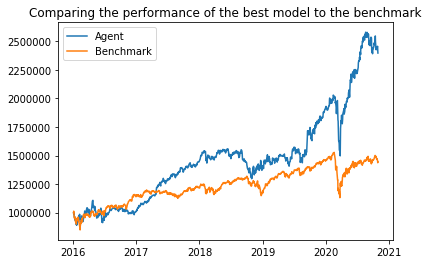

In [450]:
plt.plot(A2C_20K_timesteps_200_trades_alsointraining.Date, 
         A2C_20K_timesteps_200_trades_alsointraining.Value,
        label='Agent')

plt.plot(A2C_20K_timesteps_200_trades_alsointraining.Date, 
         A2C_20K_timesteps_200_trades_alsointraining.Benchmark_Value,
        label='Benchmark')
plt.legend()
plt.title('Comparing the performance of the best model to the benchmark')
plt.savefig('Model_performance.png')

Text(0.5, 1.0, '2016 performance')

Text(0.5, 1.0, '2020 performance')

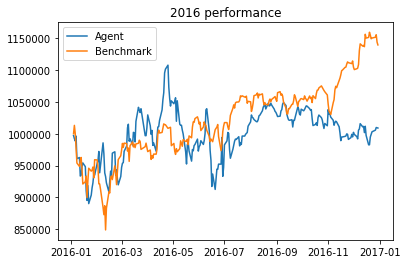

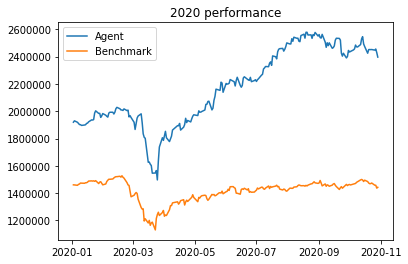

In [457]:
best_model_2016 = A2C_20K_timesteps_200_trades_alsointraining[(A2C_20K_timesteps_200_trades_alsointraining['year']=='2016')]

best_model_2020 = A2C_20K_timesteps_200_trades_alsointraining[(A2C_20K_timesteps_200_trades_alsointraining['year']=='2020')]

# fig, axs = plt.subplots(2)
# fig, (ax1, ax2) = plt.subplots(1, 2)
# axs[0].plot(best_model_2016.Date, best_model_2016.Value, label='Agent')
# axs[0].plot(best_model_2016.Date, best_model_2016.Benchmark_Value, label='Benchmark')
# axs[0].set_title("2016 performance")
# axs[0].legend()

fig1, ax1 = plt.subplots()

ax1.plot(best_model_2016.Date, best_model_2016.Value, label='Agent')
ax1.plot(best_model_2016.Date, best_model_2016.Benchmark_Value, label='Benchmark')
ax1.set_title("2016 performance")
ax1.legend()
fig1.savefig('2016Performance.png')

# axs[1].plot(best_model_2020.Date, best_model_2020.Value, label='Agent')
# axs[1].plot(best_model_2020.Date, best_model_2020.Benchmark_Value, label='Benchmark')
# axs[1].set_title("2020 performance")
fig2, ax2 = plt.subplots()
ax2.plot(best_model_2020.Date, best_model_2020.Value, label='Agent')
ax2.plot(best_model_2020.Date, best_model_2020.Benchmark_Value, label='Benchmark')
ax2.set_title("2020 performance")
ax2.legend()
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
# fig2.tight_layout()
fig2.savefig('2020Performance.png')
# import matplotlib.dates as mdates
# axs.xaxis.set_major_locator(mdates.DayLocator((1,60)))

# fig.tight_layout()

Text(0.5, 1.0, '2018 performance')

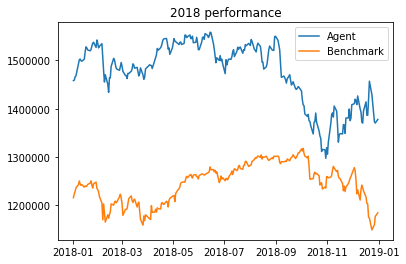

In [459]:
best_model_2018 = A2C_20K_timesteps_200_trades_alsointraining[(A2C_20K_timesteps_200_trades_alsointraining['year']=='2018')]

fig3, ax3 = plt.subplots()
ax3.plot(best_model_2018.Date, best_model_2018.Value, label='Agent')
ax3.plot(best_model_2018.Date, best_model_2018.Benchmark_Value, label='Benchmark')
ax3.set_title("2018 performance")
ax3.legend()
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

fig3.savefig('2018Performance.png')